<a href="https://colab.research.google.com/github/korea2022R4720/DFE62400/blob/main/%EB%8D%B0%EC%9D%B4%ED%84%B0%EA%B3%BC%ED%95%99_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_6%EC%A1%B0_%EB%B3%B4%ED%97%98%ED%82%A4%EC%9B%8C%EB%93%9C%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. **6조 - 초개인화 맞춤형 개인 보험**

# 데이터 수집

In [1]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 7.9 MB/s 
     |████████████████████████████████| 384 kB 85.8 MB/s 
     |████████████████████████████████| 140 kB 98.1 MB/s 
     |████████████████████████████████| 58 kB 3.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.13 which is incompatible.
Ign:1 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:3 https://

In [2]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

from datetime import datetime, timedelta
import time

from openpyxl.styles import PatternFill, Color
from openpyxl import Workbook
from random import *

In [3]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument("--single-process")

In [4]:
driver = webdriver.Chrome('chromedriver', chrome_options=chrome_options)

<ipython-input-4-c41bbb9c2f26>:1: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome('chromedriver', chrome_options=chrome_options)


## 네이버 지식인 크롤링

In [5]:
# 네이버 지식인 크롤링
# keyword에 크롤링하고 싶은 단어 선택. space 는 + 로 치환
def get_keyword(text):
    return text.replace(" ", "%20")

# 정렬 방식 선택
# 1: 추천순
# 2: 최신순
# 기타: 정확도 순
def sort_kind(index):
    # 추천
    if index == 1:
        return 'vcount'
    # 최신순
    elif index == 2:
        return 'date'
    # 정확도
    else:
        return 'none'

In [37]:
keyword = '생명보험 추천'
driver.get('https://kin.naver.com/search/list.nhn?query=' + get_keyword(keyword))
time.sleep(uniform(0.01, 0.05))

In [38]:
page_index = 1
# 크롤링 시작 일자
f = '2022.01.01'
# 크롤링 종료 일자
t = '2022.12.13'
period_txt = "&period=" + f + ".%7C" + t + "."

In [39]:
_sort_kind = sort_kind(2)
date = str(datetime.now()).replace('.', '_')
date = date.replace(' ', '_')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
my_dir = "/content/drive/MyDrive/데이터과학_6조_프로젝트/result" # 경로 변경

In [40]:
# URL 저장
f = open(my_dir +"/url_list" + "_" + keyword.replace(' ', '+') + "_" + date + ".txt", 'w')

In [41]:
page_url = []

## 크롤링 대상 페이지 url 수집 시작

In [42]:
from selenium.webdriver.common.by import By

In [43]:
while True:
    time.sleep(uniform(0.01, 0.05))
    driver.get('https://kin.naver.com/search/list.nhn?' + "&sort=" + _sort_kind + '&query=' + get_keyword(keyword) + period_txt + "&section=kin" + "&page=" + str(page_index))
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')

    tags = soup.find_all('a', class_="_nclicks:kin.txt _searchListTitleAnchor")
    for tag in tags:
        url = str(tag).split(' ')[3]
        url = url.replace('href=', "")
        url = url.replace('"', "")
        url = url.replace('amp;', '')
        page_url.append(url)
        f.write(url + "\n")

    post_number = driver.find_element(By.CLASS_NAME, 'number').text
    post_number = str(post_number).replace("(", "")
    post_number = str(post_number).replace(")", "")
    
    current_number = post_number.split('/')[0].split('-')[1]
    current_number = current_number.replace(',', '')
    total_number = post_number.split('/')[1]
    total_number = total_number.replace(',', '')

    if int(current_number) == int(total_number):
        break
    else:
        page_index += 1

In [44]:
print("page total nulm:", total_number)

page total nulm: 2289


In [18]:
filename = keyword.replace(' ', '.') + "_" + date + "_crawling_result.xlsx"

In [19]:
wb = Workbook()
sheet = wb.active
sheet.append(['제목', '질문', '답변'])

In [20]:
for j in range(1, 4):
    sheet.cell(row=1, column=j).fill = PatternFill(start_color='808080', end_color='808080', fill_type='solid')

In [21]:
count = 0

## 크롤링 시작 (네이버 지식인 질문&답변)

In [22]:
for i in page_url:
    driver.get(i)
    title = driver.find_element(By.CLASS_NAME,'title').text

    try:
        question_txt = driver.find_element(By.CLASS_NAME,'c-heading__content').text
        
    except:
        question_txt = ""

    # 답변 리스트
    answer_list = driver.find_elements(By.CLASS_NAME,"se-main-container")
    
    for n, answer in enumerate(answer_list):
        texts = answer.find_elements(By.TAG_NAME, 'span')
        t = ""
        for i in texts:
            t += i.text

        if n == 0:
            sheet.append([title, question_txt, t])
        else:
            sheet.append(["", "", t])
    
    count += 1
    print(count)
    wb.save(filename)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


# 모델링

In [ ]:
!pip install konlpy
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 4.6 MB/s 
     |████████████████████████████████| 465 kB 91.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [ ]:
train_data = pd.read_table('/content/drive/MyDrive/데이터과학_6조_프로젝트/result/LifeInsurance_result_answer.txt')

In [ ]:
train_data[:5] # 상위 5개 출력

,answer
0,보이스피싱은 아니고 보험상품 광고전화입니다현재 저는 주식일대일공부와 종목추천도 진행...
1,롯데카드측에서 전화 와서 라이나 생명인가 치아 보험을 추천하던데 보이스피싱 머 이런...
2,보험상품 권유 전화입니다. 다만 전화를 통한 일방적인 계약은 제대로 보장 설명도 못...
3,보험가입 추천전화 입니다. 치아보험 계획중이 아니라면 가입추천드리지 않아요 !!--...
4,안녕하세요 한 딸 아이의 아빠로써 한 가정의 가장으로써 우리 가족의 보험과 같이 맞...


In [ ]:
print(len(train_data)) # 리뷰 개수 출력

2432


In [ ]:
# NULL 값 존재 유무
print(train_data.isnull().values.any())

False


In [ ]:
# 결측값이 존재하면 결측값이 존재하는 행을 제거합니다.

train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [ ]:
print(len(train_data)) # 리뷰 개수 출력

2432


In [ ]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['answer'] = train_data['answer'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

<ipython-input-12-1a52e0bb9bd1>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['answer'] = train_data['answer'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [ ]:
train_data[:5] # 상위 5개 출력

,answer
0,보이스피싱은 아니고 보험상품 광고전화입니다현재 저는 주식일대일공부와 종목추천도 진행...
1,롯데카드측에서 전화 와서 라이나 생명인가 치아 보험을 추천하던데 보이스피싱 머 이런...
2,보험상품 권유 전화입니다 다만 전화를 통한 일방적인 계약은 제대로 보장 설명도 못받...
3,보험가입 추천전화 입니다 치아보험 계획중이 아니라면 가입추천드리지 않아요 답변이 조...
4,안녕하세요 한 딸 아이의 아빠로써 한 가정의 가장으로써 우리 가족의 보험과 같이 맞...


In [ ]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','그리고','또','하지만','그러나','께서는','아직','당시','때문','토록','까지만','주목','에는','이기다','또한','차라리','으로는']

## 형태소 분석(OKT)

In [ ]:
from tqdm import tqdm

In [ ]:
# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['answer']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|██████████| 2432/2432 [01:12<00:00, 33.49it/s]


답변의 최대 길이 : 1753
답변의 평균 길이 : 130.59827302631578


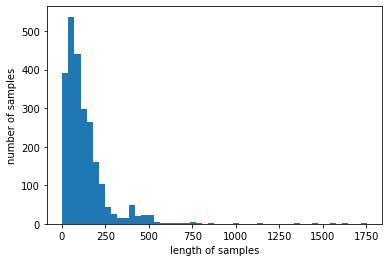

In [ ]:
# 답변 길이 분포 확인
print('답변의 최대 길이 :',max(len(answer) for answer in tokenized_data))
print('답변의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(answer) for answer in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## Word2Vec 모델

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [ ]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(2758, 100)

# 데이터 분석 결과 확인

In [ ]:
print(model.wv.most_similar("종신"))

[('정기', 0.8777535557746887), ('연금', 0.7714044451713562), ('생존', 0.7220697402954102), ('계약', 0.7209975719451904), ('피', 0.7201733589172363), ('사망', 0.7011865973472595), ('생', 0.6643803119659424), ('어린이', 0.6552284955978394), ('병자', 0.6499815583229065), ('간편', 0.6386235952377319)]


In [ ]:
print(model.wv.most_similar("보장"))

[('혜택', 0.6866629123687744), ('크게', 0.6356203556060791), ('또한', 0.6327981948852539), ('범위', 0.6312711834907532), ('좁다', 0.6269293427467346), ('종류', 0.618047833442688), ('중복', 0.6177711486816406), ('여러가지', 0.6065114736557007), ('제외', 0.605219841003418), ('특약', 0.5947614312171936)]


In [ ]:
print(model.wv.most_similar("암"))

[('유사', 0.8063013553619385), ('소액', 0.7599267959594727), ('암유', 0.7319695949554443), ('일반', 0.7256129384040833), ('막내', 0.7230274677276611), ('반', 0.6993898153305054), ('장점', 0.6959450244903564), ('분류', 0.6931607723236084), ('차라리', 0.6916234493255615), ('사암', 0.6798984408378601)]


In [ ]:
print(model.wv.most_similar("실손"))

[('의료', 0.8910387754440308), ('실비', 0.8445339202880859), ('단독', 0.8087854385375977), ('무조건', 0.7810057401657104), ('입시', 0.7809814214706421), ('세대', 0.7717523574829102), ('입', 0.7554005980491638), ('으로는', 0.7312376499176025), ('손', 0.7216483354568481), ('민영', 0.7170148491859436)]


# [참고] KoGPT2로 보험 질문 예상 답변

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.9 MB/s 
     |████████████████████████████████| 7.6 MB 47.3 MB/s 
     |████████████████████████████████| 182 kB 95.0 MB/s 


In [ ]:
import tensorflow as tf
from transformers import AutoTokenizer
from transformers import TFGPT2LMHeadModel

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('skt/kogpt2-base-v2')

Downloading:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
model = TFGPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2', from_pt=True)

Downloading:   0%|          | 0.00/513M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2LMHeadModel: ['transformer.h.11.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.7.attn.masked_bias', 'lm_head.weight', 'transformer.h.10.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.9.attn.masked_bias']
- This IS expected if you are initializing TFGPT2LMHeadModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2LMHeadModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassifica

In [ ]:
sent = '50대 생명보험 추천'

In [ ]:
input_ids = tokenizer.encode(sent)
input_ids = tf.convert_to_tensor([input_ids])
print(input_ids)

tf.Tensor([[10759  7198 12038 12100 13815]], shape=(1, 5), dtype=int32)


In [ ]:
output = model.generate(input_ids,
                        max_length=128,
                        repetition_penalty=2.0,
                        use_cache=True)
output_ids = output.numpy().tolist()[0]
print(output_ids)

[10759, 7198, 12038, 12100, 13815, 11704, 9048, 8146, 16435, 9278, 9458, 14225, 11820, 9133, 11341, 21893, 11317, 8705, 9249, 13627, 10257, 10709, 10682, 14086, 40087, 9423, 9148, 12550, 17262, 9025, 9080, 29779, 47464, 9983, 8745, 9518, 9267, 9366, 20220, 13499, 9788, 9029, 7335, 8704, 9649, 387, 11432, 8400, 22419, 21568, 7894, 6949, 6884, 7770, 8262, 9030, 21072, 13539, 9021, 14068, 7600, 10030, 12743, 25151, 8104, 9168, 13119, 49176, 26263, 26421, 9018, 36407, 39290, 12298, 8135, 31746, 10950, 9044, 26113, 19231, 9764, 46470, 7489, 20580, 9508, 7975, 9185, 15025, 16402, 8137, 39997, 9846, 9068, 25171, 16451, 10017, 11841, 14110, 12618, 9033, 10599, 15177, 8393, 7824, 13764, 9510, 9922, 9511, 9072, 6848, 7890, 11148, 7235, 11613, 8711, 12364, 8220, 27233, 29670, 473, 410, 408, 7162, 10769, 10251, 9125, 11557, 9430]


In [ ]:
tokenizer.decode(output_ids)

'50대 생명보험 추천 상품이다.\n이 상품의 가장 큰 특징은 가입 후 1년 이내에 사망할 경우 보험금을 지급한다는 점이다.\n가입 당시부터 보장받을 수 있는 종신보험의 기본형보다 더 많은 금액을 받을 수도 있다.\n또한 암, 뇌출혈, 급성심근경색증 등 중대한 질병으로 진단받으면 최대 1억원까지 추가 보장을 해준다.\n특히 이 상품에 가입한 고객은 납입기간 중 매월 10만원의 보험료만 내면 된다.\n암이나 심장질환을 앓고 있을 때 발병률이 높은 만큼 미리 대비하는 것도 중요하다.\n최소 10년 이상 유지하면 비갱신형으로도 전환해 준다.\n종신·CI·DB는 물론 각종 특약을 통해'

In [ ]:
import numpy as np

In [ ]:
output = model(input_ids)

In [ ]:
output.logits

<tf.Tensor: shape=(1, 6, 51200), dtype=float32, numpy=
array([[[-5.747002  , -4.9288535 , -4.671458  , ..., -3.3013077 ,
         -5.290155  , -3.6403728 ],
        [-4.3961835 , -4.3396244 , -4.068678  , ..., -1.3737171 ,
         -0.86896753, -0.06575503],
        [-5.7232604 , -4.6476645 , -4.5017953 , ..., -0.07470087,
         -5.4750667 , -4.987732  ],
        [-5.920431  , -4.976571  , -6.1295223 , ..., -2.7914653 ,
         -6.086825  , -3.4714725 ],
        [-5.885958  , -6.332714  , -5.6098013 , ..., -2.2744255 ,
         -7.524918  , -6.1215806 ],
        [-5.6277976 , -5.7099714 , -5.623121  , ..., -2.0050058 ,
         -3.204608  , -5.5362945 ]]], dtype=float32)>

In [ ]:
output.logits.shape

TensorShape([1, 6, 51200])

In [ ]:
top5 = tf.math.top_k(output.logits[0, -1], k=5)

In [ ]:
tokenizer.convert_ids_to_tokens(top5.indices.numpy())

['▁종신', '▁보장', '▁20', '▁평균', '▁보험']